In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [242]:
import inspect
inspect.getsourcelines(preprocessing.scale) 

(['def scale(X, axis=0, with_mean=True, with_std=True, copy=True):\n',
  '    """Standardize a dataset along any axis\n',
  '\n',
  '    Center to the mean and component wise scale to unit variance.\n',
  '\n',
  '    Read more in the :ref:`User Guide <preprocessing_scaler>`.\n',
  '\n',
  '    Parameters\n',
  '    ----------\n',
  '    X : {array-like, sparse matrix}\n',
  '        The data to center and scale.\n',
  '\n',
  '    axis : int (0 by default)\n',
  '        axis used to compute the means and standard deviations along. If 0,\n',
  '        independently standardize each feature, otherwise (if 1) standardize\n',
  '        each sample.\n',
  '\n',
  '    with_mean : boolean, True by default\n',
  '        If True, center the data before scaling.\n',
  '\n',
  '    with_std : boolean, True by default\n',
  '        If True, scale the data to unit variance (or equivalently,\n',
  '        unit standard deviation).\n',
  '\n',
  '    copy : boolean, optional, default True\n',

In [2]:
test_size=0.2

df_train = pd.read_csv(r'train.csv')
df_train.index = df_train.PassengerId

y = df_train.Survived.values
df_train = df_train.drop(['Survived'], axis=1)

#remove columns
df_train = df_train.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)

#fill n/a
df_train['Age'] = df_train.Age.fillna(-1)
df_train['Embarked'] = df_train.Embarked.fillna('X')

#one hot encoding. OK to do it for all data, inlcuding df_predict
df_train['Sex'] = (df_train.Sex == 'male').astype(int)

df_dummy = pd.get_dummies(df_train.Embarked, prefix='Embarked')
df_train = df_train.drop(['Embarked'], axis=1)
df_train = pd.concat((df_train, df_dummy), axis=1)

#df_train
#df_predict

X = df_train.values
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=test_size, random_state=0)

#scale: X = (X - X.mean(axis=0))/np.sqrt(X.var(axis=0))
#X = preprocessing.scale(X)

#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(712, 10)
(712,)
(179, 10)
(179,)


In [100]:
df_train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

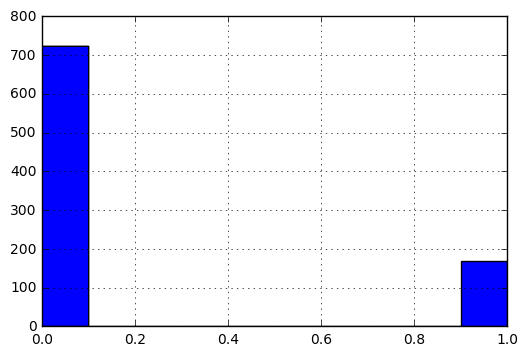

In [119]:
df_train.Embarked_C.hist()
plt.show()

In [22]:
np.random.seed(0) # set a seed so that the results are consistent

clfs = [sklearn.linear_model.LogisticRegressionCV(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1)]  

for clf in clfs:
    clf.fit(X_train, y_train);
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    predictions = clf.predict(X_dev)
    accuracy2 = accuracy_score(predictions, y_dev)
    print(type(clf), accuracy, accuracy2)
   

<class 'sklearn.linear_model.logistic.LogisticRegressionCV'> 0.803370786517 0.804469273743
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.981741573034 0.843575418994


In [67]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
        


In [133]:
np.random.seed(0) # set a seed so that the results are consistent
initializer = keras.initializers.RandomUniform(minval=0, maxval=0.01, seed=None)
#RandomNormal works much better
#initializer = keras.initializers.RandomNormal()
regularizer = None
#regularizer = regularizers.l2(0.1)
model = Sequential()
model.add(Dense(20, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(20, kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(10, kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', kernel_regularizer=regularizer))
optimizer = optimizers.SGD(lr=0.05)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [134]:
np.random.seed(0) # set a seed so that the results are consistent
initial_epoch = 0
epochs = 100000
verbose = 0
verbose2 = 1000
batch_size = int(X_train_k.shape[0])

results = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)

Y_predict_k = model.predict(X_train_k)
Y_predict_k = Y_predict_k > 0.5
print('Accuracy train', accuracy_score(Y_train_k, Y_predict_k))

Y_predict_k = model.predict(X_dev_k)
Y_predict_k = Y_predict_k > 0.5
print('Accuracy dev', accuracy_score(Y_dev_k, Y_predict_k))

0 0.693147242069 0.435393244028 0.614525139332
1000 0.665717661381 0.616573035717 0.614525139332
2000 0.665717542171 0.616573035717 0.614525139332
3000 0.665717542171 0.616573035717 0.614525139332
4000 0.665717601776 0.616573035717 0.614525139332
5000 0.665717542171 0.616573035717 0.614525139332
6000 0.665717542171 0.616573035717 0.614525139332
7000 0.665717244148 0.616573035717 0.614525139332
8000 0.665717244148 0.616573035717 0.614525139332
9000 0.665717244148 0.616573035717 0.614525139332
10000 0.665717244148 0.616573035717 0.614525139332
11000 0.665717184544 0.616573035717 0.614525139332
12000 0.665717124939 0.616573035717 0.614525139332
13000 0.665717065334 0.616573035717 0.614525139332
14000 0.665717065334 0.616573035717 0.614525139332
15000 0.665717124939 0.616573035717 0.614525139332
16000 0.665717363358 0.616573035717 0.614525139332
17000 0.665717184544 0.616573035717 0.614525139332
18000 0.665717065334 0.616573035717 0.614525139332
19000 0.66571688652 0.616573035717 0.6145251

In [ ]:
20/20/20/1, lr=0.1
  100000 95.78 78.77
20/20/10/1, lr=0.05
  100000 92.97 75.41
    
+lambd=0.1

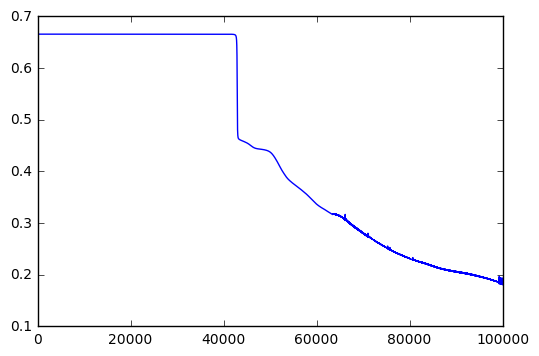

In [135]:
plt.plot(results.history['loss'])
plt.show()

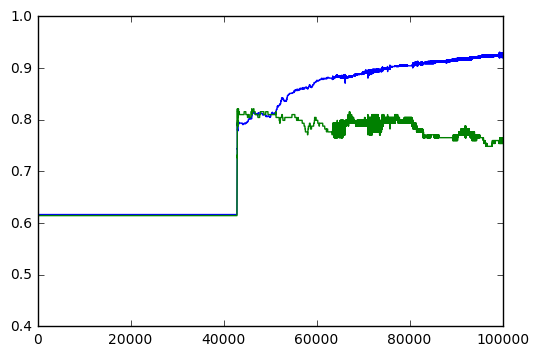

In [136]:
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.show()

In [34]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [35]:
#random seed for mini batch shuffle
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(10, np.tanh)
dnn.add_layer(10, np.tanh)
dnn.add_layer(1, DNN.sigmoid)
dnn.costfunction = DNN.binary_crossentropy
dnn.init = 'Lecun'
dnn.compile()

In [39]:
#random seed for mini batch shuffle
np.random.seed(0)

learning_rate = 0.01
num_iterations = 100000
batch_size = int(X_train_my.shape[1])
verbose = 1000
gradient_check = False

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='error', learning_rate=learning_rate, batch_size=batch_size, num_iterations=num_iterations, verbose=verbose, gradient_check=gradient_check)

Y_predict_my = dnn.predict(X_train_my)
Y_predict_my = Y_predict_my > 0.5
accuracy = accuracy_score(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1]))
print('Accuracy train', accuracy)

Y_predict_my = dnn.predict(X_dev_my)
Y_predict_my = Y_predict_my > 0.5
accuracy = accuracy_score(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1]))
print('Accuracy dev', accuracy)


.
Cost after iteration 0 ['0.397462', '0.838483', '0.787709']
.
Cost after iteration 1000 ['0.391828', '0.832865', '0.793296']
.
Cost after iteration 2000 ['0.386577', '0.834270', '0.793296']
.
Cost after iteration 3000 ['0.381520', '0.839888', '0.787709']
.
Cost after iteration 4000 ['0.376555', '0.844101', '0.782123']
.
Cost after iteration 5000 ['0.371793', '0.844101', '0.787709']
.
Cost after iteration 6000 ['0.367481', '0.845506', '0.804469']
.
Cost after iteration 7000 ['0.363736', '0.851124', '0.804469']
.
Cost after iteration 8000 ['0.360514', '0.852528', '0.804469']
.
Cost after iteration 9000 ['0.357715', '0.855337', '0.815642']
.
Cost after iteration 10000 ['0.355243', '0.855337', '0.798883']
.
Cost after iteration 11000 ['0.353023', '0.855337', '0.798883']
.
Cost after iteration 12000 ['0.351004', '0.855337', '0.793296']
.
Cost after iteration 13000 ['0.349144', '0.858146', '0.793296']
.
Cost after iteration 14000 ['0.347409', '0.859551', '0.793296']
.
Cost after iteration 

In [ ]:
10/10 0.01/110K
Accuracy train 0.893258426966
Accuracy dev 0.787709497207

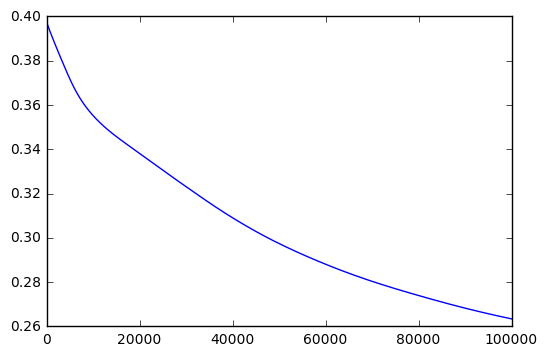

In [40]:
plt.plot(results['loss'])
plt.show()

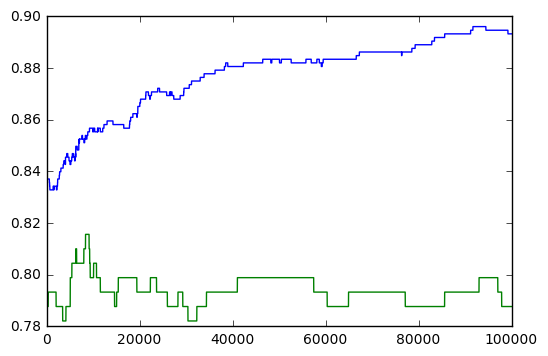

In [41]:
plt.plot(results['eval0'])
plt.plot(results['eval1'])
plt.show()

In [21]:
epsilon=1e-7
approx = np.array([(np.power((10+epsilon), 3) - np.power((10-epsilon), 3))/2/epsilon])
approx

array([ 299.99999811])

In [22]:
grad = np.array([300])

In [23]:
grad - approx

array([  1.89429556e-06])

In [24]:
numerator = np.linalg.norm(grad - aprox)                     
denominator = np.linalg.norm(grad) + np.linalg.norm(approx)   
difference = numerator/denominator                                
difference

3.1571592847220796e-09

In [26]:
a=np.array([[1,2],[3,4]])
a[0,0]

1

In [27]:
a


array([[1, 2],
       [3, 4]])